# Try programmatic access to PO.DAAC cloud data from local computer


### What I originally wanted to do with this notebook is to choose a target region and time period, cycle through a bunch of high-resolution sea surface temperature data obtained from the PO.DAAC cloud, identify clear images, catalog them

### What I want to do with this notebook is to access data in the PO.DAAC cloud and download to my local machine
### - Most preferable would be to access with xarray or opendap 


@jtomfarrar

This was modified from this notebook:
https://github.com/NASA-Openscapes/nch2021-projects-contexdata/blob/main/notebooks/find_VIIRS_SST.ipynb

The major change I want to make is to run the notebook locally on my computer, rather than on the Amazon Cloud.

- We will use L3 VIIRS SST here, PO.DAAC short name "VIIRS_NPP-OSPO-L3U-v2.61"


Some useful info I learned before at PO.DAAC cloud computing hackathon (~Nov 2021)
1. We can query the NASA Common Metadata Repository to find out the names and “concept ID” of datasets (url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'); see example below in this notebook
1. To download data (to cloud or local machine), you need a _netrc file (on windows) or .netrc file (on linux) to pass NASA EarthData credentials and get S3 access;—see Tutorial 4, https://github.com/NASA-Openscapes/2021-Cloud-Hackathon/blob/main/tutorials/04_NASA_Earthdata_Authentication.ipynb ; this is needed in “def begin_s3_direct_access()” below; for direct download, it would also be needed
1. We were working in the Amazon Cloud using the “2i2c Hub Service”:
https://openscapes.2i2c.cloud/hub/login?next=%2Fhub%2F


Things I just learned (Jan 2022):
1. The podaac-data-subscriber (PDS) seems like a good way to download data (from the cloud or wherever?): https://github.com/podaac/data-subscriber
1. At least on a Windows PC, it seems like the PDS requires a netrc file that is ".netrc" (like on a mac/linux system) instead of "\_netrc" (like on a Windows system), regardless of OS.  That is, on a windows system, you need to make a copy of your "\_netrc" file and rename it as ".netrc"
1. I guess S3 direct access will only work from the cloud.  I could use a "try" statement like in this notebook: https://github.com/podaac/tutorials/blob/master/notebooks/Pre-SWOT_Numerical_Simulation_Demo.ipynb


To do:
- [ ] Go through include statements and remove unnecessary ones
- [ ] Clean up this notebook to remove broken parts
- [ ] Re-order things so podaac-data-subscriber solution is first, then try opendap some more


In [1]:
#Pretty sure some of these are extraneous

# import s3fs
import os
import os.path
import json
import warnings
import requests

from urllib import request
from platform import system

import numpy as np
import pandas as pd
import xarray as xr
# from io import StringIO

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import FormatStrFormatter
from matplotlib import ticker, rc, cm

# Used for accessing files via xarray (in order to pass credentials)
from pydap.client import open_url
from pydap.cas.urs import setup_session

# Used for plotting maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy

# import geoviews as gv
# import hvplot.xarray
# import holoviews as hv
# gv.extension('bokeh', 'matplotlib')

warnings.filterwarnings("ignore")

%matplotlib inline
# %matplotlib qt5

In [2]:
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 700

## PO DAAC Catalog exploration using the CMR API

- The search is restricted to colections that have data over a given time window

In [3]:
provider = 'POCLOUD'
url = 'https://cmr.earthdata.nasa.gov/search/collections.umm_json'
response = requests.get(url,
                        params={
                            'cloud_hosted': 'True',
                            'has_granules': 'True',
                            'provider': provider,
                            'page_size': 500,
                            'temporal': ['2021-10-01T10:00:00Z','2021-11-01T00:00:00Z'] 
                        },
                        headers={
                            'Accept': 'application/json'
                        }
                       )
response.headers['cmr-hits']

'150'

### Loop through each response in the catalog and print the respective concept ID

These are the data sets that cover the time period of interest

In [4]:
#  If set to "True", this will show short names and concept ids for all PO.DAAC data sets at this time
if True:
    for r in response.json()['items']:
        print('{} ==> '.format(r['meta']['s3-links'][0].split('/')[1]), r['meta']['concept-id'])

JASON_CS_S6A_L2_ALT_LR_STD_OST_NRT_F ==>  C1968979597-POCLOUD
MUR-JPL-L4-GLOB-v4.1 ==>  C1996881146-POCLOUD
JASON_CS_S6A_L2_ALT_HR_STD_OST_NRT_F ==>  C1968979566-POCLOUD
JASON_CS_S6A_L2_ALT_LR_STD_OST_STC_F ==>  C1968980609-POCLOUD
JASON_CS_S6A_L2_ALT_HR_STD_OST_NTC_F_UNVALIDATED ==>  C1968980590-POCLOUD
JASON_CS_S6A_L2_ALT_HR_STD_OST_STC_F ==>  C1968980583-POCLOUD
JASON_CS_S6A_L2_ALT_LR_STD_OST_NTC_F_UNVALIDATED ==>  C1968979551-POCLOUD
MODIS_A-JPL-L2P-v2019.0 ==>  C1940473819-POCLOUD
MODIS_T-JPL-L2P-v2019.0 ==>  C1940475563-POCLOUD
MUR25-JPL-L4-GLOB-v4.2 ==>  C2036880657-POCLOUD
VIIRS_N20-OSPO-L2P-v2.61 ==>  C1996880450-POCLOUD
VIIRS_N20-OSPO-L3U-v2.61 ==>  C2036878688-POCLOUD
VIIRS_NPP-OSPO-L2P-v2.61 ==>  C1996880725-POCLOUD
VIIRS_NPP-OSPO-L3U-v2.61 ==>  C2036877595-POCLOUD
ABI_G16-STAR-L2P-v2.70 ==>  C2036877465-POCLOUD
ABI_G16-STAR-L3C-v2.70 ==>  C2036877612-POCLOUD
ABI_G17-STAR-L2P-v2.71 ==>  C2036877626-POCLOUD
ABI_G17-STAR-L3C-v2.71 ==>  C2036877645-POCLOUD
AHI_H08-STAR-L2P-v2.

## Set some parameters (start/end time and lat/lon bounds)


In [5]:
# Center location
site = 'S-MODE'

if site == 'S-MODE':
    lon0 = -123.5
    lat0 = 37.5 
    dlon = 2.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-2':
    lon0 = -125
    lat0 = 10
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat
elif site == 'SPURS-1':
    lon0 = -38
    lat0 = 25
    dlon = 1.5 # half of box width in lon
    dlat = 1.5 # half of box width in lat

# Define the max/min lon
lon_min = lon0 - dlon
lon_max = lon0 + dlon
lat_min = lat0 - dlat
lat_max = lat0 + dlat

In [6]:
if site == 'S-MODE':
    start_time = '2021-10-20T00:00:00Z'
    end_time = '2021-11-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2016-8-20T00:00:00Z'
    end_time = '2017-11-6T00:00:00Z'
elif site == 'SPURS-2':
    start_time = '2012-9-15T00:00:00Z'
    end_time = '2013-11-15T00:00:00Z'



In [7]:
url = 'https://cmr.earthdata.nasa.gov/search/granules'

# VIIRS_NPP-OSPO-L2P-v2.61 ==>  C1996880725-POCLOUD
# concept_id = 'C2036880650-POCLOUD' #  MODIS
# concept_id = 'C1996880725-POCLOUD' # VIIRS_NPP-OSPO-L2P-v2.61 
concept_id = 'C2036877595-POCLOUD' # VIIRS_NPP-OSPO-L3U-v2.61 
response = requests.get(url, 
                        params={
                            'concept_id': concept_id,
                            'temporal': start_time+','+end_time,
                            'bounding_box': '{},{},{},{}'.format(lon_min, lat_min, lon_max, lat_max),    
                            'page_size': 500,
                            },
                        headers={
                            'Accept': 'application/json'
                            }
                       )
print(response)
print(response.headers['CMR-Hits'])

<Response [200]>
94


In [8]:
granules_url = []
for gran in response.json()['feed']['entry']:
    granules_url.append(gran['links'][4]['href'])
# granules_url
len(granules_url)

94

In [9]:
gran

{'boxes': ['7.88 -150.44 46.61 -108.77'],
 'time_start': '2021-11-05T21:30:00.000Z',
 'updated': '2021-11-05T22:21:13.722Z',
 'dataset_id': 'GHRSST Level 3U OSPO dataset v2.61 from VIIRS on S-NPP Satellite (GDS v2)',
 'data_center': 'POCLOUD',
 'title': '20211105213000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0',
 'coordinate_system': 'CARTESIAN',
 'day_night_flag': 'UNSPECIFIED',
 'time_end': '2021-11-05T21:39:59.000Z',
 'id': 'G2159445200-POCLOUD',
 'original_format': 'UMM_JSON',
 'granule_size': '4.286630630493164',
 'browse_flag': False,
 'collection_concept_id': 'C2036877595-POCLOUD',
 'online_access_flag': True,
 'links': [{'rel': 'http://esipfed.org/ns/fedsearch/1.1/s3#',
   'title': 'This link provides direct download access via S3 to the granule.',
   'hreflang': 'en-US',
   'href': 's3://podaac-ops-cumulus-protected/VIIRS_NPP-OSPO-L3U-v2.61/20211105213000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0.nc'},
  {'rel': 'http://esipfed.org/ns/fe

In [10]:
granules_url[1]

'https://opendap.earthdata.nasa.gov/collections/C2036877595-POCLOUD/granules/20211020115000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0'

## One solution is to use podaac-data-subscriber to download the data

See:
https://github.com/podaac/data-subscriber

In [11]:
short_name = 'VIIRS_NPP-OSPO-L3U-v2.61'
# !podaac-data-subscriber -c $short_name -d ../data_tom/. --start-date $start_time --end-date $end_time

## Another solution is to load the data via opendap, but it is tricky because we need to pass credentials for S3

The tricky part is that we need to pass our Earthdata login credentials to AWS.  This will not work:
```
url = 'https://opendap.earthdata.nasa.gov/collections/C2036877595-POCLOUD/granules/20211020101000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0'
ds = xr.open_dataset(url)
```

I had to ask PO.DAAC for help (thank you to Tim McKnight and an unnamed software engineer).  This does work:
```
import xarray as xr
from pydap.client import open_url
from pydap.cas.urs import setup_session

session = setup_session("username", "password")
store = xr.backends.PydapDataStore.open('https://opendap.earthdata.nasa.gov/collections/C2036877595-POCLOUD/granules/20211020101000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0',
session=session)
ds = xr.open_dataset(store)
```

In [12]:
file_list =  granules_url
filename =  granules_url[0]
filename

'https://opendap.earthdata.nasa.gov/collections/C2036877595-POCLOUD/granules/20211020101000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0'

In [14]:
session = setup_session("username", "password")
store = xr.backends.PydapDataStore.open('https://opendap.earthdata.nasa.gov/collections/C2036877595-POCLOUD/granules/20211020101000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0',
session=session)
ds = xr.open_dataset(store)


In [15]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 9000, lon: 18000, time: 1)
Coordinates:
  * lat                      (lat) float32 89.99 89.97 89.95 ... -89.97 -89.99
  * lon                      (lon) float32 -180.0 -180.0 -179.9 ... 180.0 180.0
  * time                     (time) object 2021-10-20 10:10:02
Data variables:
    wind_speed               (time, lat, lon) float32 ...
    sses_standard_deviation  (time, lat, lon) float32 ...
    sst_dtime                (time, lat, lon) timedelta64[ns] ...
    l2p_flags                (time, lat, lon) int16 ...
    sea_surface_temperature  (time, lat, lon) float32 ...
    quality_level            (time, lat, lon) float32 ...
    dt_analysis              (time, lat, lon) float32 ...
    satellite_zenith_angle   (time, lat, lon) float32 ...
    or_number_of_pixels      (time, lat, lon) float32 ...
    sses_bias                (time, lat, lon) float32 ...
    crs                      int32 ...
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    SSTs are a weighted average of the SSTs of co...
    creator_email:              Alex.Ignatov@noaa.gov
    creator_name:               Alex Ignatov
    creator_url:                http://www.star.nesdis.noaa.gov
    date_created:               20211020T123049Z
    easternmost_longitude:      -94.25999451
    file_quality_level:         2
    gds_version_id:             02.0
    geospatial_lat_max:         60.45999908
    geospatial_lat_min:         21.22999954
    geospatial_lat_resolution:  0.01999999955
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         -94.25999451
    geospatial_lon_min:         -144.8099976
    geospatial_lon_resolution:  0.01999999955
    geospatial_lon_units:       degrees_east
    history:                    Created by the L2P-to-L3U conversion tool,  w...
    id:                         VIIRS_NPP-OSPO-L3-v2.61
    institution:                NOAA/NESDIS/OSPO
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    license:                    GHRSST protocol describes data use as free an...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    naming_authority:           org.ghrsst
    netcdf_version_id:          4.5.0 of Jul 20 2018 12:34:15 $
    northernmost_latitude:      60.45999908
    platform:                   NPP
    processing_level:           L3U
    product_version:            L2P algorithm V2.61; L3U algorithm V3.9.6
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    references:                 Data convention: GHRSST Data Specification (G...
    sensor:                     VIIRS
    source:                     l2p_source : 20211020101000-OSPO-L2P_GHRSST-S...
    southernmost_latitude:      21.22999954
    spatial_resolution:         0.02 deg
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    start_time:                 20211020T101001Z
    stop_time:                  20211020T102000Z
    summary:                    Sea surface temperature retrievals produced b...
    time_coverage_end:          20211020T102000Z
    time_coverage_start:        20211020T101001Z
    title:                      VIIRS L3 SST
    uuid:                       dbdfb1fa-ae89-4b4e-963c-eace3390f798
    westernmost_longitude:      -144.8099976
    aggregator_version:         V1.00
    preprocessor_version:       1.14
    sst_luts:                   LUT_VIIRS_NPP_L2P_DEPTH_DAY_V01.04_20181217.t...
    geospatial_bounds:  

In [16]:
filename =  granules_url[2]
filename

'https://opendap.earthdata.nasa.gov/collections/C2036877595-POCLOUD/granules/20211020195000-OSPO-L3U_GHRSST-SSTsubskin-VIIRS_NPP-ACSPO_V2.61-v02.0-fv01.0'

In [19]:
def open_podaac_file(filename):
    session = setup_session("username", "password")
    store = xr.backends.PydapDataStore.open(filename, session=session)
    ds = xr.open_dataset(store)
    return ds

In [20]:
ds = open_podaac_file(filename)

In [21]:
ds

<xarray.Dataset>
Dimensions:                  (lat: 9000, lon: 18000, time: 1)
Coordinates:
  * lat                      (lat) float32 89.99 89.97 89.95 ... -89.97 -89.99
  * lon                      (lon) float32 -180.0 -180.0 -179.9 ... 180.0 180.0
  * time                     (time) object 2021-10-20 19:50:01
Data variables:
    wind_speed               (time, lat, lon) float32 ...
    sses_standard_deviation  (time, lat, lon) float32 ...
    sst_dtime                (time, lat, lon) timedelta64[ns] ...
    l2p_flags                (time, lat, lon) int16 ...
    sea_surface_temperature  (time, lat, lon) float32 ...
    quality_level            (time, lat, lon) float32 ...
    dt_analysis              (time, lat, lon) float32 ...
    satellite_zenith_angle   (time, lat, lon) float32 ...
    or_number_of_pixels      (time, lat, lon) float32 ...
    sses_bias                (time, lat, lon) float32 ...
    crs                      int32 ...
Attributes:
    Conventions:                CF-1.6, ACDD-1.3
    Metadata_Conventions:       Unidata Dataset Discovery v1.0
    acknowledgement:            Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    SSTs are a weighted average of the SSTs of co...
    creator_email:              Alex.Ignatov@noaa.gov
    creator_name:               Alex Ignatov
    creator_url:                http://www.star.nesdis.noaa.gov
    date_created:               20211020T203159Z
    easternmost_longitude:      -84.44999695
    file_quality_level:         2
    gds_version_id:             02.0
    geospatial_lat_max:         53.15999985
    geospatial_lat_min:         14.2699995
    geospatial_lat_resolution:  0.01999999955
    geospatial_lat_units:       degrees_north
    geospatial_lon_max:         -84.44999695
    geospatial_lon_min:         -129.5800018
    geospatial_lon_resolution:  0.01999999955
    geospatial_lon_units:       degrees_east
    history:                    Created by the L2P-to-L3U conversion tool,  w...
    id:                         VIIRS_NPP-OSPO-L3-v2.61
    institution:                NOAA/NESDIS/OSPO
    keywords:                   Oceans > Ocean Temperature > Sea Surface Temp...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Sc...
    license:                    GHRSST protocol describes data use as free an...
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    naming_authority:           org.ghrsst
    netcdf_version_id:          4.5.0 of Jul 20 2018 12:34:15 $
    northernmost_latitude:      53.15999985
    platform:                   NPP
    processing_level:           L3U
    product_version:            L2P algorithm V2.61; L3U algorithm V3.9.6
    project:                    Group for High Resolution Sea Surface Tempera...
    publisher_email:            ghrsst-po@nceo.ac.uk
    publisher_name:             The GHRSST Project Office
    publisher_url:              http://www.ghrsst.org
    references:                 Data convention: GHRSST Data Specification (G...
    sensor:                     VIIRS
    source:                     l2p_source : 20211020195000-OSPO-L2P_GHRSST-S...
    southernmost_latitude:      14.2699995
    spatial_resolution:         0.02 deg
    standard_name_vocabulary:   CF Standard Name Table (v26, 08 November 2013)
    start_time:                 20211020T195000Z
    stop_time:                  20211020T195959Z
    summary:                    Sea surface temperature retrievals produced b...
    time_coverage_end:          20211020T195959Z
    time_coverage_start:        20211020T195000Z
    title:                      VIIRS L3 SST
    uuid:                       9f7d4989-08ba-46a3-8c1b-2fc2b0fb9c7f
    westernmost_longitude:      -129.5800018
    aggregator_version:         V1.00
    preprocessor_version:       1.14
    sst_luts:                   LUT_VIIRS_NPP_L2P_DEPTH_DAY_V01.04_20181217.t...
    geospatial_bounds:    

In [34]:
# For S3 direct access (in-cloud)
# file_list =  [fs.open(file) for file in granules_url]

ds = xr.open_mfdataset(*.nc,drop_variables=['dt_analysis','satellite_zenith_angle','sses_bias','wind speed']).sel(lon=slice(lon_min,lon_max), lat=slice(lat_max,lat_min))

SyntaxError: invalid syntax (<ipython-input-34-efe381b2ac6a>, line 4)

## Make a metric to select times with clear skies in region of interest

The idea here is to choose a box defining region of interest and use quality flag or NaN mask to count bad/good pixels


In [14]:
# Define a box where we want data (may be different than larger analysis domain)
# Still centered on lon0,lat0
dlon = 0.5 # half of box width in lon
dlat = 0.5 # half of box width in lat

# Define the max/min lon
x1 = lon0 - dlon
x2 = lon0 + dlon
y1 = lat0 - dlat
y2 = lat0 + dlat

In [15]:
# Make a time series in that box
# Compute mean value of "not NaN" (notnull) in the box
good_data = ds.sea_surface_temperature.sel(lat=slice(y2,y1), lon=slice(x1,x2)).notnull().mean({'lon','lat'})
np.shape(good_data)

NameError: name 'ds' is not defined

In [16]:
fig = plt.figure(figsize=(4,3),dpi=200)
plt.plot(good_data['time'],good_data,marker='o')
fig.autofmt_xdate()
plt.title('Values near 1 indicate clear skies')

NameError: name 'good_data' is not defined

<Figure size 800x600 with 0 Axes>

In [17]:
good_times = good_data['time'].where(good_data>0.95,drop=True)
np.shape(good_times)

NameError: name 'good_data' is not defined

In [18]:
good_times[-1].values

NameError: name 'good_times' is not defined

## Choose a particular time


In [19]:
# Find the data near this time
d = good_times[-1] # np.datetime64('2021-11-05T00:00:00Z')

NameError: name 'good_times' is not defined

In [20]:
ds2 = ds.sel(time=d,method='nearest')

NameError: name 'ds' is not defined

In [21]:
# This string of the time of the SST selected will be useful
day_str = np.datetime_as_string(ds2.time,unit='m')

NameError: name 'ds2' is not defined

NameError: name 'day_str' is not defined

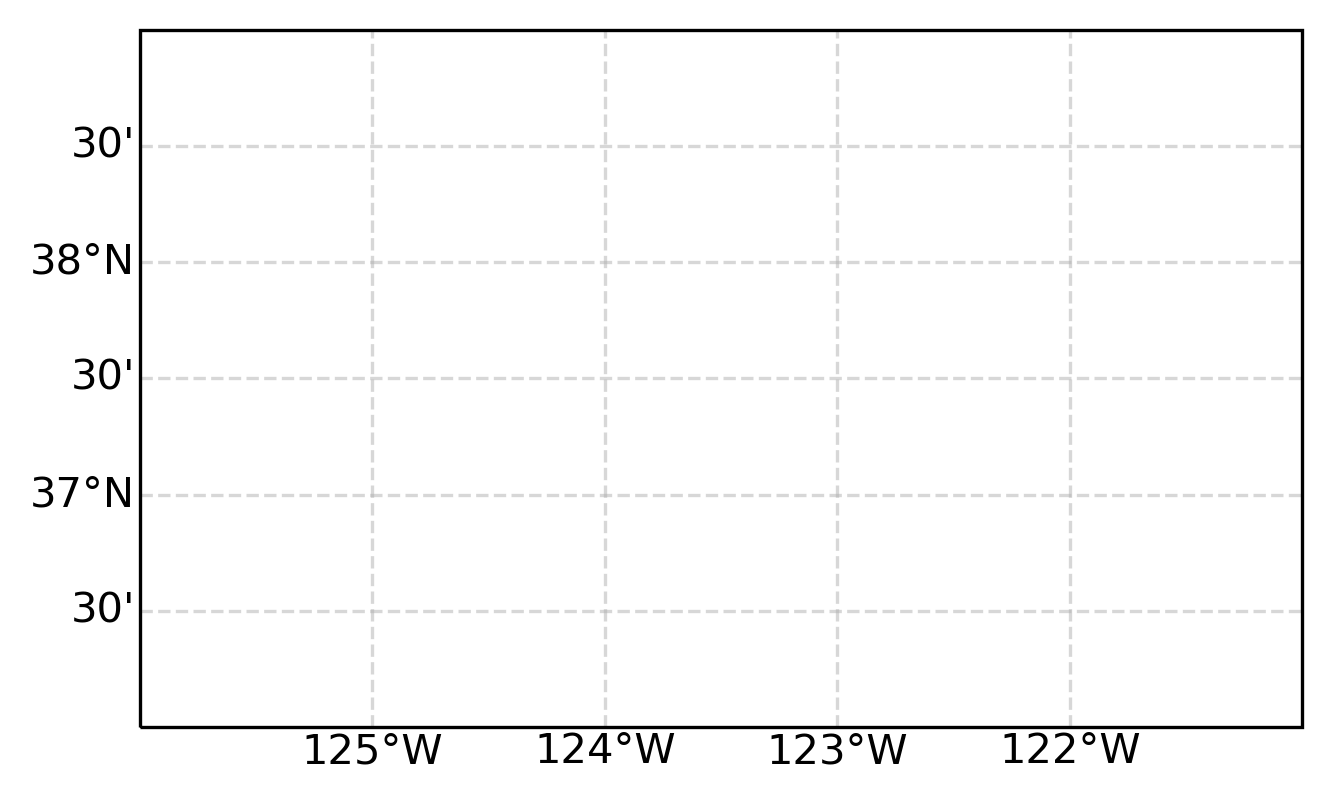

In [22]:
fig = plt.figure()
ax = plt.axes(projection = ccrs.PlateCarree(central_longitude=-125))  # Orthographic
extent = [lon_min, lon_max,lat_min, lat_max]
ax.set_extent(extent, crs=ccrs.PlateCarree())


plt.set_cmap(cmap=plt.get_cmap('turbo'))
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax.set_title('SST, ' + day_str, size = 10.)

ax.coastlines()
ax.add_feature(cartopy.feature.LAND, zorder=3, facecolor=[.6,.6,.6], edgecolor='black')
cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze()-274.15,vmin=12.5,vmax=15,transform=ccrs.PlateCarree())
# cs = ax.pcolormesh(ds2.lon,ds2.lat,ds2.sea_surface_temperature.squeeze().notnull(),transform=ccrs.PlateCarree())
cb = plt.colorbar(cs,fraction = 0.022,extend='both')
cb.set_label('SST [$\circ$C]',fontsize = 10)


In [49]:
try:
    !del .update
except:
    # Load netCDF with 'xarray' after download completes:


SyntaxError: invalid syntax (<ipython-input-51-fe07ef939298>, line 2)